In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# -*- coding: utf-8 -*-
"""
Created on Fri Oct 07 10:35:29 2016

@author: Job Verkaik, Mattijn van Hoek, HKV Lijn in water
"""
from os.path import isdir
#from fewslogger import Logger
import datetime
import sys, getopt, shutil
import netCDF4
import numpy as np
from xml.etree import ElementTree

#Functions 
#=======================================================================================
def createNETCDF(filename, in_nc_arr="", STATE_COPY_CREATE=0, TIME_LIST=[], HM_ARRAY=[], fillValue = -999.0):
    """
    filename           ::  path to new NETCDF file
    in_nc_arr          ::  base NETCDF file
    STATE_COPY_CREATE  ::  set 0 for state
                           set 1 for copy
                           set 2 for create
    TIME_LIST          ::  when creating, provide datetime array with dates
    HM_ARRAY           ::  provide array with h.m data to create NETCDF
    fillValue          ::  only used during creation [default: -999.0] 
    """
    # 0 is TimeSeriesSet STATE FILE
    # 1 is TimeSeriesSet COPY
    # 2 is TimeSeriesSet CREATE
    # ------------------------------------------            
    # create new warmState
    # create new.nc url and open file to write
    new_nc = filename
    nc_new = netCDF4.Dataset(new_nc, 'w', format="NETCDF3_CLASSIC")

    # create dimensions for new nc file based on in.nc
    if STATE_COPY_CREATE == 0 :
        nt = 1
    elif STATE_COPY_CREATE == 1:
        nt = in_nc_arr.dimensions['time'].size
    elif STATE_COPY_CREATE == 2:
        nt = len(TIME_LIST)        
    ny = in_nc_arr.dimensions['y'].size
    nx = in_nc_arr.dimensions['x'].size
    nc_new.createDimension('time', nt)
    nc_new.createDimension('y', ny)
    nc_new.createDimension('x', nx)

    # copy over time variable from in.nc [only first slice]
    time_innc = in_nc_arr.variables['time']
    time = nc_new.createVariable('time', 'f8', ('time',))
    if STATE_COPY_CREATE == 0:
        time[:] = time_innc[-1]
    elif STATE_COPY_CREATE == 1:
        time[:] = time_innc[:]
    elif STATE_COPY_CREATE == 2:
        time[:] = TIME_LIST
#     ws_epoch_min = time_innc[-1] * 60
#     ws_datetime = datetime.datetime.fromtimestamp(ws_epoch_min).strftime('%Y-%m-%d')
#     log.write(3,"This is updateDepth.py: warmStateTime in datetime: "+str(ws_datetime))
    time.standard_name = time_innc.standard_name
    time.long_name = time_innc.long_name
    time.units = time_innc.units
    time.axis = time_innc.axis

    # copy over y variable from in.nc
    y_innc = in_nc_arr.variables['y']
    y = nc_new.createVariable('y', 'f8', ('y',), fill_value = y_innc._FillValue ) 
    y[:] = y_innc[:]
    y.standard_name = y_innc.standard_name
    y.long_name = y_innc.long_name
    y.units = y_innc.units
    y.axis = y_innc.axis

    # copy over x variable from in.nc
    x_innc = in_nc_arr.variables['x']
    x = nc_new.createVariable('x', 'f8', ('x'), fill_value = x_innc._FillValue)
    x[:] = x_innc[:]
    x.standard_name = x_innc.standard_name
    x.long_name = x_innc.long_name
    x.units = x_innc.units
    x.axis = x_innc.axis

    # copy over z variable from in.nc
    z_innc = in_nc_arr.variables['z']
    z = nc_new.createVariable('z', 'f8', ('y', 'x'), fill_value = z_innc._FillValue)
    z[:] = z_innc[:]
    z.long_name = z_innc.long_name
    z.units = z_innc.units
    z.axis = z_innc.axis
    try:
        z.postive = z_innc.positive
    except:
        l = 1

    # copy over lat variable from in.nc
    lat_innc = in_nc_arr.variables['lat']
    lat = nc_new.createVariable('lat', 'f8', ('y', 'x'), fill_value = lat_innc._FillValue)
    lat[:] = lat_innc[:]
    lat.standard_name = lat_innc.standard_name
    lat.long_name = lat_innc.long_name
    lat.units = lat_innc.units

    # copy over lat variable from in.nc
    lon_innc = in_nc_arr.variables['lon']
    lon = nc_new.createVariable('lon', 'f8', ('y', 'x'), fill_value = lon_innc._FillValue)
    lon[:] = lon_innc[:]
    lon.standard_name = lon_innc.standard_name
    lon.long_name = lon_innc.long_name
    lon.units = lon_innc.units

    # copy over crs variable from in.nc
    crs_innc = in_nc_arr.variables['crs']
    crs = nc_new.createVariable('crs', 'i4', ())
    crs.long_name = crs_innc.long_name
    crs.crs_wkt = crs_innc.crs_wkt
    crs.proj4_params = crs_innc.proj4_params
    crs.epsg_code = crs_innc.epsg_code

    # copy over HM variable from in.nc [only first slice]
    HM_innc = in_nc_arr.variables['HM']
    if STATE_COPY_CREATE == 0:
        noDataVal = HM_innc._FillValue
    elif STATE_COPY_CREATE == 1:
        noDataVal = HM_innc._FillValue
    elif STATE_COPY_CREATE == 2:
        noDataVal = fillValue
    HM = nc_new.createVariable('HM', 'f8', ('time', 'y', 'x'), fill_value = noDataVal)
    HM[:] = HM_ARRAY[:]
    #HM[:] = hm_out[:]
    HM.long_name = HM_innc.long_name
    HM.units = HM_innc.units
    HM.coordinates = HM_innc.coordinates
    HM.grid_mapping = HM_innc.grid_mapping

    #close newly created warmState nc file
    nc_new.close()        
#=======================================================================================


In [3]:
inputdir = r'D:\Projects\Pr\3317.20\Annemieke\depthUpdate_grid074\depthUpdate\input'
statedir = r'D:\Projects\Pr\3317.20\Annemieke\depthUpdate_grid074\depthUpdate\state'
outputdir = r'D:\Projects\Pr\3317.20\Annemieke\depthUpdate_grid074\depthUpdate\output'
runfiledir = r'D:\Projects\Pr\3317.20\Annemieke\depthUpdate_grid074\depthUpdate\runfile' 

In [6]:
# # 
# # # MAIN PROGRAM  
# # def main(argv):
# #     # input argument checking
# try:
#     opts, args = getopt.getopt(argv,"hi:o:s:r:",["ipath=","spath=","opath=","rpath="])
# except getopt.GetoptError:
#     print ('usage: updateDepth.py -i <inputdir> -s <statedir> -o <outputdir> -r <runfiledir>')
#     sys.exit(2)
# for opt, arg in opts:
#     if opt == '-h':
#         print ('updateDepth.py -i <inputdir> -s <statedir> -o <outputdir> -r <runfiledir>')
#         sys.exit()
#     elif opt in ("-i", "--inputdir"):
#         inputdir = arg
#     elif opt in ("-s", "--statedir"):
#         statedir = arg
#     elif opt in ("-o", "--outputdir"):
#         outputdir = arg
#     elif opt in ("-r", "--runfiledir"):
#         runfiledir = arg            

# diagnosticsfile = "diagnostics.xml"
# log = Logger(diagnosticsfile)
# log.write(3,"This is updateDepth.py: doe iets slims; M. van Hoek &amp; J. Verkaik, HKV Lijn in water")
# log.write(4,"Inputdir: %s" % inputdir)
# log.write(4,"Statedir: %s" % statedir)
# log.write(4,"Outputdir: %s" % outputdir)
# log.write(4,"Runfiledir: %s" % runfiledir)    
# log.write(4,"Diagnosticsfile: %s" % diagnosticsfile)


try:
    # DOE IETS SLIMS VANAF HIER

    #shutil.copyfile("%s/in.nc" % inputdir, "%s/out.nc" % outputdir)

    # load input netcdf and state netcdf
    # in_nc = r'D:\OMS_Waddenzee\trunk\fews\Modules\depthUpdate4pythontesting\input//in.nc'
    # state_nc = r'D:\OMS_Waddenzee\trunk\fews\Modules\depthUpdate4pythontesting\state//state.nc'
    # out_nc = r'D:\OMS_Waddenzee\trunk\fews\Modules\depthUpdate4pythontesting\output//out.nc'

    in_nc = "%s/in.nc" % inputdir
    state_nc = "%s/state.nc" % statedir
    out_nc = "%s/out.nc" % outputdir

    in_nc_arr = netCDF4.Dataset(in_nc, )
    state_nc_arr = netCDF4.Dataset(state_nc, )
    # print(in_nc_arr)

    # print(in_nc_arr.variables.keys()) # get all variable names
    hm = in_nc_arr.variables['HM']  # bodemhoogte peiling
    hm_state = state_nc_arr.variables['HM']  # coldState
    hm_state_time = state_nc_arr.variables['time']  # coldState
    cs_epoch_min = hm_state_time[0] * 60
    cs_datetime = datetime.datetime.fromtimestamp(cs_epoch_min).strftime('%Y-%m-%d')        
#     log.write(3,"This is updateDepth.py: coldStateTime in ms since epoch: "+str(cs_datetime))




    ###_#@%#$%@#$!@$@$%#$%^@#$%!@#$!@$
#     # create copy in.nc
#     hm_copy = np.copy(hm)
#     hm_copy = np.ma.masked_equal(hm_copy, -999)

#     # use coldState to update first slice in.nc
#     a = hm[0,::] 
#     b = hm_state[0,::]
#     # update first slice based on coldState
#     a[~b.mask] = b.compressed()
#     hm_copy[0,::] = a

#     # create init warmState
#     hm_out = hm_copy[0,::]

#     for ix in range(hm.shape[0] - 1):    
#         # print (ix)
#         # one by one fill/update and ammend arrays
#         # get first slice of copy, get second slice of original
#         a = hm[ix,::] 
#         b = hm[ix+1,::]  
  
#         # update first slice based on second slice
#         a[~b.mask] = b.compressed()
#         # update timeSeriesSet
#         hm_copy[ix+1,::] = a    
#         # update warmState
#         hm_out[~a.mask] = a.compressed()        

        
        
    ###_#@%#$%@#$!@$@$%#$%^@#$%!@#$!@$
        
    # create copy in.nc
    hm_copy = np.copy(hm)
    hm_copy = np.ma.masked_equal(hm, -999)

    # use coldState to update first slice in.nc
    a = hm[0,::] 
    b = hm_state[0,::]
    # update first slice based on coldState
    a[~b.mask] = b.compressed()
    hm_copy[0,::] = a

    # create init warmState
    hm_out = hm_copy[0,::]

    for ix in range(hm.shape[0] - 1):    
        # print (ix)
        # one by one fill/update and ammend arrays
        # get first slice of copy, get second slice of original
        a = hm[ix,::] 
        b = hm[ix+1,::]  

        # update first slice based on second slice
        a[~b.mask] = b.compressed()
        # update timeSeriesSet
        hm_copy[ix+1,::] = a    
        # update warmState
        hm_out[~a.mask] = a.compressed()  

        ###_#@%#$%@#$!@$@$%#$%^@#$%!@#$!@$
        
    # ------------------------------------------            
    # create new warmState
    # create NETCDF file for new timeSeriesSet        
#     createNETCDF(state_nc, in_nc_arr = in_nc_arr, STATE_COPY_CREATE = 0, HM_ARRAY = hm_out )


#     # ------------------------------------------
#     # create out.nc timeSeriesSet
#     # create new.nc url and open file to write
# #     createNETCDF(out_nc, in_nc_arr = in_nc_arr, STATE_COPY_CREATE = 1, HM_ARRAY = hm_copy )


except:
    print('doet het niet')
#     try:        
#         state_nc = "%s/state.nc" % statedir
#         runfile_xml = "%s/runfile.xml" % runfiledir
#         state_nc_arr = netCDF4.Dataset(state_nc, )
#         hm_state = state_nc_arr.variables['HM']  # coldState
#         hm_state_time = state_nc_arr.variables['time']  # coldState
#         cs_epoch_min = hm_state_time[0] * 60
#         cs_date = datetime.datetime.fromtimestamp(cs_epoch_min)#.strftime('%Y-%m-%d')    

#         # open runfile.xml and get time0 date in datetime format
#         e = ElementTree.parse(runfile_xml).getroot()
#         time0 = e[3].attrib.get('date') # e[3] is time0 in xml file

#         time0_list = time0.replace('-', ' ').split(' ')
#         time0_date = datetime.datetime(int(time0_list[0]), int(time0_list[1]), int(time0_list[2]),2)   

#         # get new datelist in MINUTES since epoch
#         numdays = time0_date - cs_date
#         datesISO = [time0_date - datetime.timedelta(days=x) for x in range(0, numdays.days + 1)]

#         datesEpoch = []
#         for date in datesISO:
#             datesEpoch.append(date.timestamp() / 60.)    
#         datesEpoch.reverse()
#         # create numpy array of epoch
#         #datesEpoch = np.array(datesEpoch)

#         # repeat array N times where N is number of days between state and time0
#         N = len(datesEpoch)
#         A = np.array(hm_state[0,::])
#         B = np.asarray([A]*N)

#         # mask nodata values
#         hm_out = np.ma.masked_equal(B, -999)

#         # create NETCDF file for new timeSeriesSet        
#         createNETCDF(out_nc, in_nc_arr = state_nc_arr, STATE_COPY_CREATE = 2, TIME_LIST = datesEpoch, HM_ARRAY = hm_out )

#         # open out_NC as input for new WarmStateFile
#         out_nc_arr = netCDF4.Dataset(out_nc, )    
#         newHM_out = hm_out[-1]

#         # create NETCDF file for new WarmStateFile        
#         createNETCDF(state_nc, in_nc_arr = out_nc_arr, STATE_COPY_CREATE = 0, HM_ARRAY = newHM_out )             


#     except:
#         print ('doet het helegaar niet')
# #         if not (isdir(inputdir)):
# #             log.write(1,"%s is not a valid path" % inputdir)
# #         elif not (isdir(statedir)):
# #             log.write(1,"%s is not a valid path" % statedir)
# #         elif not (isdir(outputdir)):
# #             log.write(1,"%s is not a valid path" % outputdir)
# #         elif not (isdir(runfiledir)):
# #             log.write(1,"%r is not a valid path" % runfiledir)
# #         else:
# #             log.write(1,"something else is funky")            

# # TOT HIER
# log.write(3,"Dat was het, FEWS take over please")
# log.close()

# if __name__ == "__main__":
# main(sys.argv[1:])

c:\python35\lib\site-packages\ipykernel\__main__.py:104: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
c:\python35\lib\site-packages\ipykernel\__main__.py:121: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


0


c:\python35\lib\site-packages\numpy\ma\core.py:4145: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


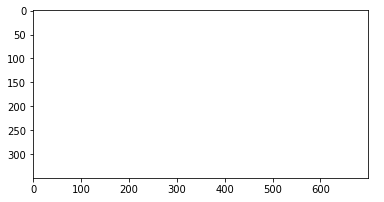

1


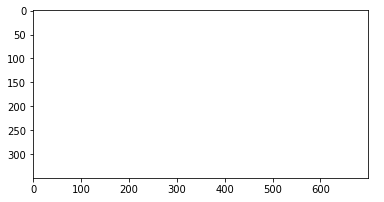

2


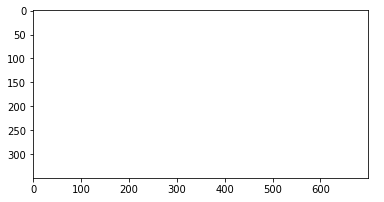

3


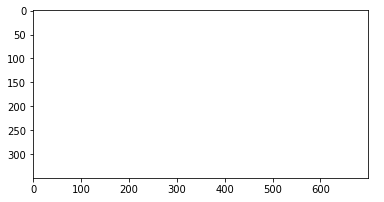

4


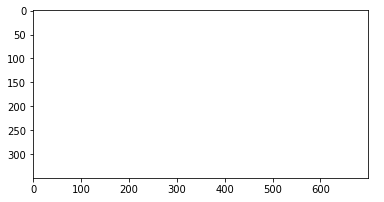

5


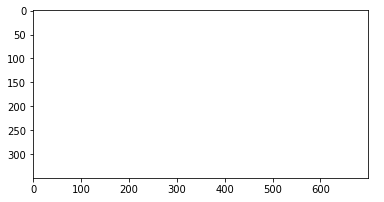

6


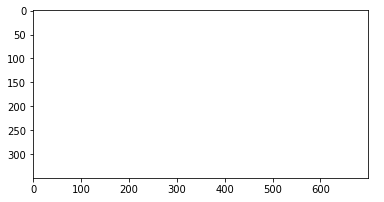

7


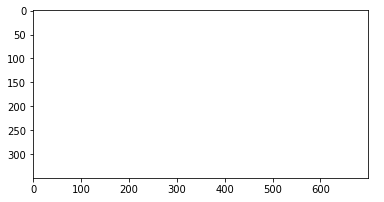

8


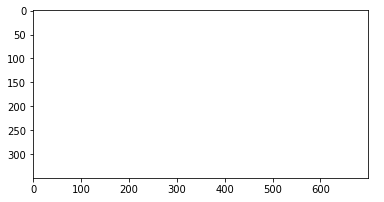

9


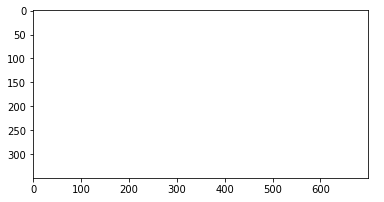

10


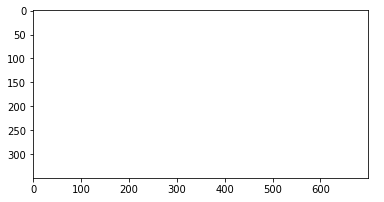

11


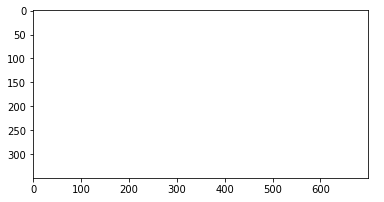

12


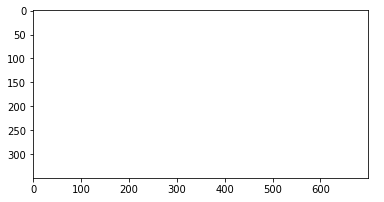

13


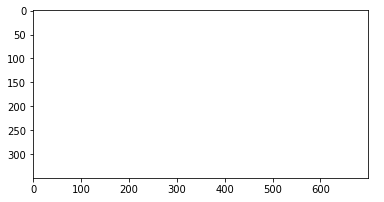

14


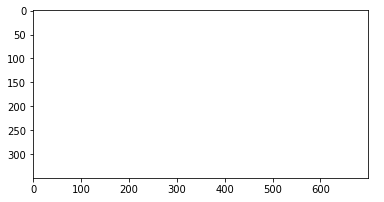

15


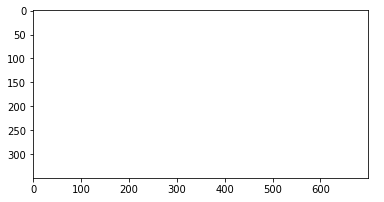

16


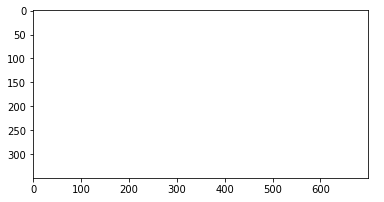

17


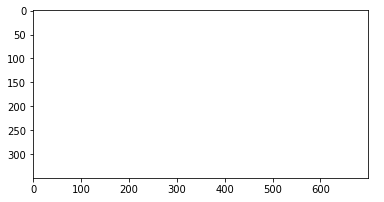

18


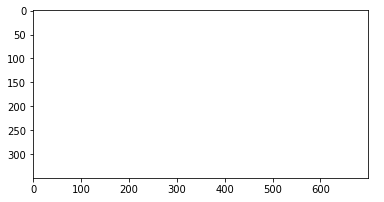

19


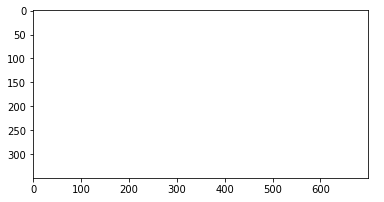

20


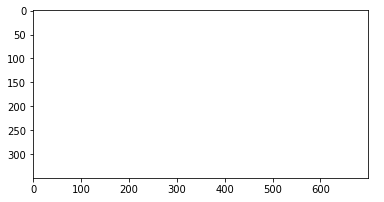

21


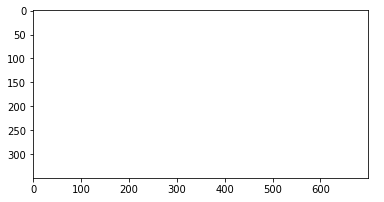

22


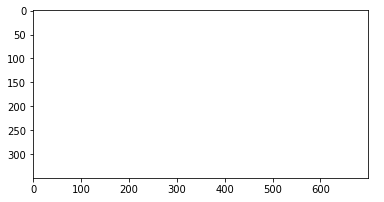

23


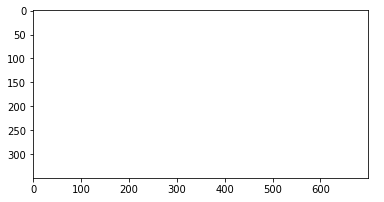

24


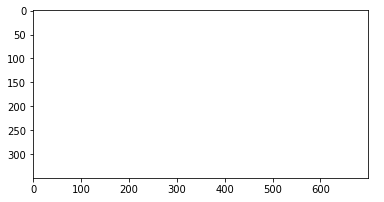

25


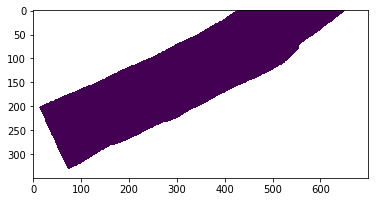

26


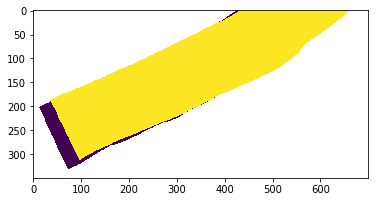

27


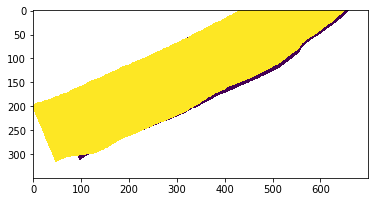

28


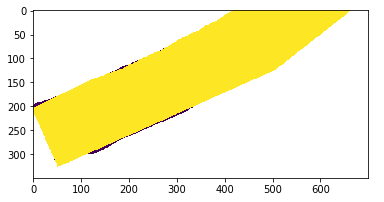

29


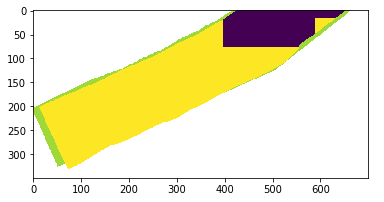

30


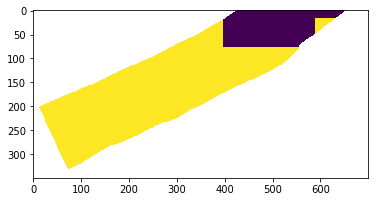

In [5]:
for ix in range(hm_copy.shape[0]):
    print(ix)
    
    plt.imshow(hm_copy[ix,:,:])
    plt.show()

In [ ]:
hm.shape